##Library

In [ ]:
# Data manipulation & analysis
import pandas as pd
import shap, numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & modeling
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor



##Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
delivery_path = "/content/drive/MyDrive/Dataset/delivery.csv"

In [ ]:
df = pd.read_csv(delivery_path)

##Dataset Understanding

In [ ]:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [ ]:
print(df.shape)
print(df.columns)
df.info()
df.describe()
df.nunique()


(1000, 9)
Index(['Order_ID', 'Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day',
       'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs',
       'Delivery_Time_min'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


,0
Order_ID,1000
Distance_km,785
Weather,5
Traffic_Level,3
Time_of_Day,4
Vehicle_Type,3
Preparation_Time_min,25
Courier_Experience_yrs,10
Delivery_Time_min,108


##Data Cleaning

###MIssing Value Handling

In [ ]:
print(df.isnull().sum())

Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64


In [ ]:
# Imputasi categorical
for col in ["Weather", "Traffic_Level", "Time_of_Day"]:
    df[col].fillna("Unknown", inplace=True)

# Imputasi numerical
df["Courier_Experience_yrs"].fillna(df["Courier_Experience_yrs"].median(), inplace=True)

/tmp/ipython-input-1783587426.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("Unknown", inplace=True)
/tmp/ipython-input-1783587426.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

In [ ]:
print(df.isnull().sum())

Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64


###Duplicate Handling

In [ ]:
print(df.duplicated().sum())

0


###Data Filter

In [ ]:
df = df[df["Distance_km"] > 0]
df = df[df["Preparation_Time_min"] >= 0]
df = df[df["Courier_Experience_yrs"] >= 0]

##Exploratory Data Analysist

###Distribution of Target Variable

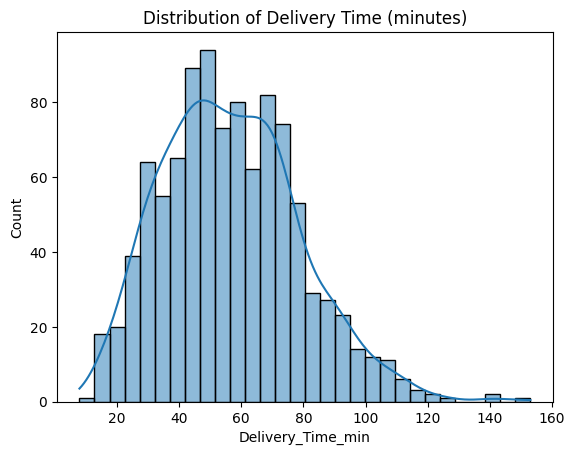

In [ ]:
sns.histplot(df["Delivery_Time_min"], bins=30, kde=True)
plt.title("Distribution of Delivery Time (minutes)")
plt.show()

###Correlation among Numerical Variables

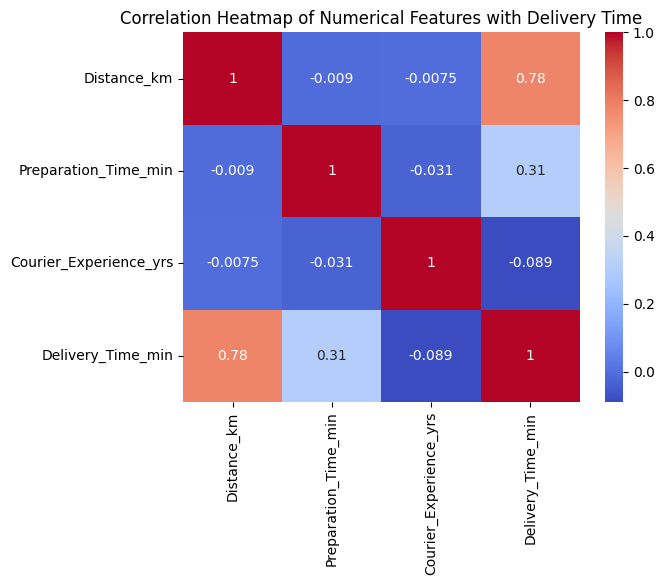

In [ ]:
sns.heatmap(df[["Distance_km","Preparation_Time_min","Courier_Experience_yrs","Delivery_Time_min"]].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features with Delivery Time")
plt.show()


###Relationship between Distance and Delivery Time

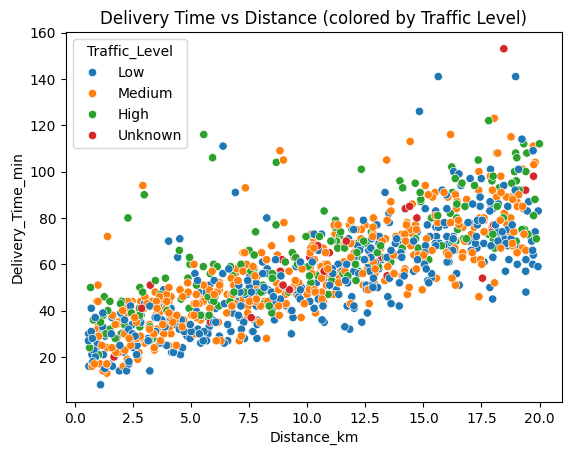

In [ ]:
sns.scatterplot(x="Distance_km", y="Delivery_Time_min", hue="Traffic_Level", data=df)
plt.title("Delivery Time vs Distance (colored by Traffic Level)")
plt.show()


###Impact of Weather Conditions on Delivery Time

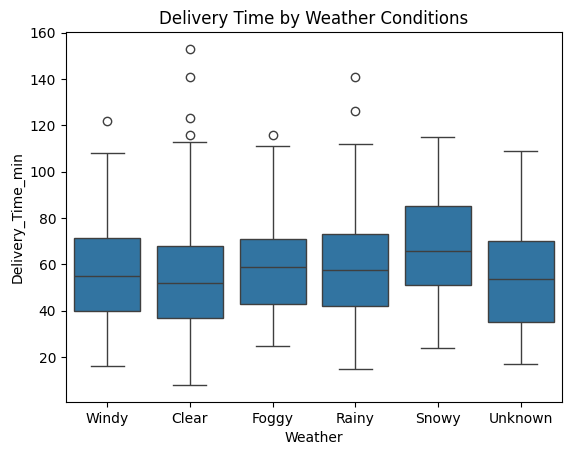

In [ ]:
sns.boxplot(x="Weather", y="Delivery_Time_min", data=df)
plt.title("Delivery Time by Weather Conditions")
plt.show()


###Impact of Traffic Level on Delivery Time

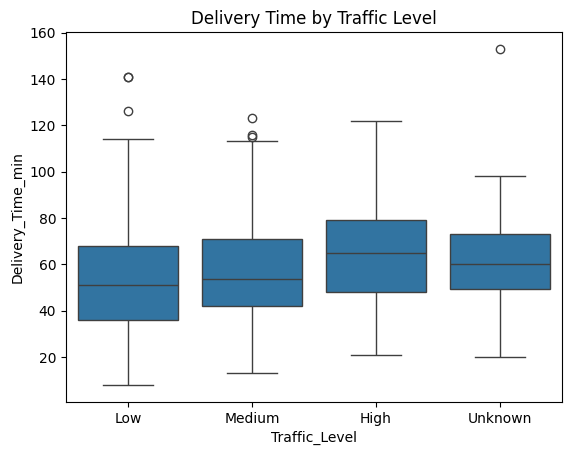

In [ ]:
sns.boxplot(x="Traffic_Level", y="Delivery_Time_min", data=df)
plt.title("Delivery Time by Traffic Level")
plt.show()


###Impact of Time of day on Delivery Time

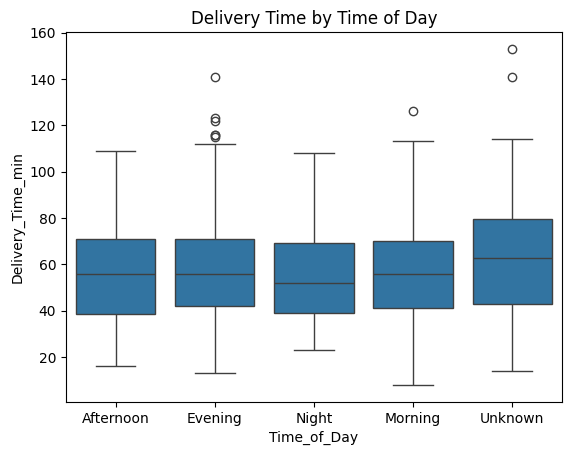

In [ ]:
sns.boxplot(x="Time_of_Day", y="Delivery_Time_min", data=df)
plt.title("Delivery Time by Time of Day")
plt.show()


###Impact of Vehicle Type on Delivery Time

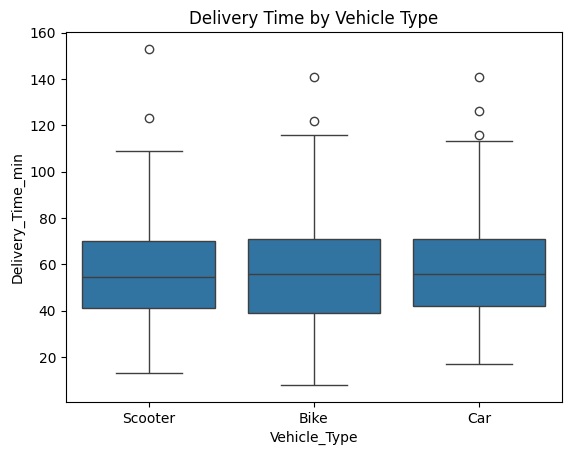

In [ ]:
#Vehicle Type
sns.boxplot(x="Vehicle_Type", y="Delivery_Time_min", data=df)
plt.title("Delivery Time by Vehicle Type")
plt.show()


##Feature Engineering

###Flag Unkown

In [ ]:
for col in ["Weather", "Traffic_Level", "Time_of_Day"]:
    df[f"{col}_isUnknown"] = (df[col] == "Unknown").astype(int)


###Ordinal Map Traffic Level

In [ ]:
traffic_map = {"Low": 1, "Medium": 2, "High": 3, "Unknown": 0}
df["Traffic_Level_Num"] = df["Traffic_Level"].map(traffic_map)

###Intrecation : Distance x Traffic

In [ ]:
df["Distance_Traffic"] = df["Distance_km"] * df["Traffic_Level_Num"]

###Durasi awal: Prep + Distance

In [ ]:
df["Total_Prep_and_Travel"] = df["Preparation_Time_min"] + df["Distance_km"]


###Bad Weather Impact

In [ ]:
bad_weather = {"Rainy", "Snowy", "Foggy"}
df["Bad_Weather"] = df["Weather"].isin(bad_weather).astype(int)

df["Scooter_in_Bad_Weather"] = (
    (df["Vehicle_Type"] == "Scooter") & (df["Bad_Weather"] == 1)
).astype(int)


###Courrier Experience

In [ ]:
bins = [0, 1, 5, 100]
labels = ["Newbie", "Intermediate", "Expert"]
df["Courier_Experience_Level"] = pd.cut(
    df["Courier_Experience_yrs"], bins=bins, labels=labels, include_lowest=True
)


###Peak Hour

In [ ]:
peak = {"Morning", "Evening"}
df["Is_Peak_Hour"] = df["Time_of_Day"].isin(peak).astype(int)

In [ ]:
num_cols = [
    "Distance_km",
    "Preparation_Time_min",
    "Courier_Experience_yrs",
    "Traffic_Level_Num",
    "Distance_Traffic",
    "Total_Prep_and_Travel",
    "Bad_Weather",
    "Scooter_in_Bad_Weather",
    "Is_Peak_Hour",
    "Weather_isUnknown",
    "Traffic_Level_isUnknown",
    "Time_of_Day_isUnknown",
]

cat_cols = [
    "Weather",
    "Traffic_Level",
    "Time_of_Day",
    "Vehicle_Type",
    "Courier_Experience_Level",
]


##Modelling

###Helper evaluator & Preprocessor

In [ ]:
def eval_train_test(model, X_train, y_train, X_test, y_test, name="Model"):
    y_pred_tr = model.predict(X_train)
    y_pred_te = model.predict(X_test)
    mae_tr = mean_absolute_error(y_train, y_pred_tr)
    rmse_tr = np.sqrt(mean_squared_error(y_train, y_pred_tr))
    r2_tr = r2_score(y_train, y_pred_tr)
    mae_te = mean_absolute_error(y_test, y_pred_te)
    rmse_te = np.sqrt(mean_squared_error(y_test, y_pred_te))
    r2_te = r2_score(y_test, y_pred_te)
    print(f"\n=== {name} ===")
    print(f"Train -> MAE: {mae_tr:.3f} | RMSE: {rmse_tr:.3f} | R²: {r2_tr:.3f}")
    print(f"Test  -> MAE: {mae_te:.3f} | RMSE: {rmse_te:.3f} | R²: {r2_te:.3f}")

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)
sc_mae  = make_scorer(mean_absolute_error, greater_is_better=False)
sc_rmse = make_scorer(lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)), greater_is_better=False)

def report_cv(pipe, X, y, name="Model"):
    r2   = cross_val_score(pipe, X, y, cv=cv5, scoring="r2")
    mae  = -cross_val_score(pipe, X, y, cv=cv5, scoring=sc_mae)
    rmse = -cross_val_score(pipe, X, y, cv=cv5, scoring=sc_rmse)
    print(f"\n=== {name} | 5-fold CV ===")
    print(f"R²   : {r2.mean():.3f} ± {r2.std():.3f}")
    print(f"MAE  : {mae.mean():.3f} ± {mae.std():.3f}")
    print(f"RMSE : {rmse.mean():.3f} ± {rmse.std():.3f}")

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

###Data Split

In [ ]:
X = df[num_cols + cat_cols].copy()
y = df["Delivery_Time_min"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

##Model Comparission

###Random Forest

In [ ]:
pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])
pipe_rf.fit(X_train, y_train)
eval_train_test(pipe_rf, X_train, y_train, X_test, y_test, "Random Forest")


=== Random Forest ===
Train -> MAE: 2.812 | RMSE: 4.577 | R²: 0.958
Test  -> MAE: 6.909 | RMSE: 9.860 | R²: 0.783


In [ ]:
param_dist_rf = {
    "model__n_estimators": [200, 300, 500, 800],
    "model__max_depth": [5, 10, 15, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", 0.8],
    "model__bootstrap": [True]
}

rand_rf = RandomizedSearchCV(
    pipe_rf, param_distributions=param_dist_rf,
    n_iter=20, cv=5, scoring="neg_mean_absolute_error",
    n_jobs=-1, random_state=42, verbose=0
)
rand_rf.fit(X_train, y_train)
print("Best params (RF):", rand_rf.best_params_)


Best params (RF): {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': 0.8, 'model__max_depth': None, 'model__bootstrap': True}


In [ ]:
best_rf = rand_rf.best_estimator_
eval_train_test(best_rf, X_train, y_train, X_test, y_test, "Random Forest (Tuned)")


=== Random Forest (Tuned) ===
Train -> MAE: 4.846 | RMSE: 8.127 | R²: 0.867
Test  -> MAE: 6.696 | RMSE: 9.601 | R²: 0.794


In [ ]:
report_cv(best_rf, df[num_cols + cat_cols], df["Delivery_Time_min"], "Random Forest")



=== Random Forest | 5-fold CV ===
R²   : 0.744 ± 0.048
MAE  : 7.246 ± 0.619
RMSE : 11.130 ± 1.503


RF Test -> MAE: 6.696 | RMSE: 9.601 | R²: 0.794


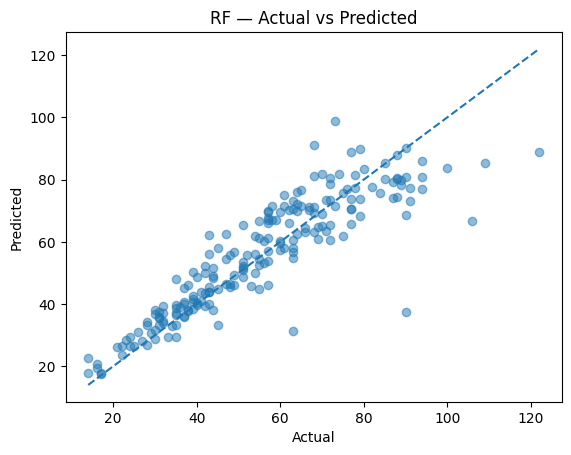

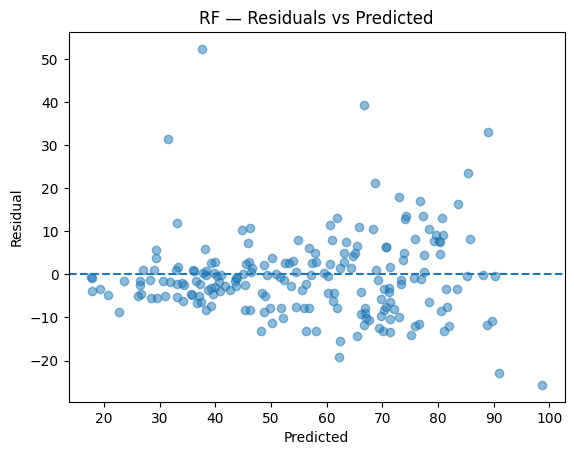

In [ ]:
pred_rf = best_rf.predict(X_test)

print("RF Test -> MAE:", round(mean_absolute_error(y_test, pred_rf), 3),
      "| RMSE:", round(np.sqrt(mean_squared_error(y_test, pred_rf)), 3),
      "| R²:", round(r2_score(y_test, pred_rf), 3))

plt.scatter(y_test, pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], ls="--")
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("RF — Actual vs Predicted"); plt.show()

res_rf = y_test - pred_rf
plt.scatter(pred_rf, res_rf, alpha=0.5)
plt.axhline(0, ls="--")
plt.xlabel("Predicted"); plt.ylabel("Residual"); plt.title("RF — Residuals vs Predicted"); plt.show()


###XGboost

In [ ]:
pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("model", xgb.XGBRegressor(
        random_state=42,
        tree_method="hist",
        n_jobs=-1,
        verbosity=0,
        eval_metric="rmse"
    ))
])


In [ ]:
param_dist = {
    "model__n_estimators": [200, 400, 800, 1200],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__max_depth": [3, 5, 7],
    "model__subsample": [0.7, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.9, 1.0],
    "model__reg_lambda": [0.5, 1.0, 2.0],
    "model__reg_alpha": [0, 0.1, 0.5],
}

rand_xgb = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=0,
    random_state=42
)

rand_xgb.fit(X_train, y_train)
print("Best params (CV):", rand_xgb.best_params_)
print("Best CV MAE:", -rand_xgb.best_score_)


Best params (CV): {'model__subsample': 0.7, 'model__reg_lambda': 2.0, 'model__reg_alpha': 0, 'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.7}
Best CV MAE: 7.165426572163899


In [ ]:
best_xgb = rand_xgb.best_estimator_

In [ ]:
eval_train_test(best_xgb, X_train, y_train, X_test, y_test, "XGBoost Tuned")



=== XGBoost Tuned ===
Train -> MAE: 5.347 | RMSE: 8.365 | R²: 0.859
Test  -> MAE: 6.316 | RMSE: 9.236 | R²: 0.810


In [ ]:
report_cv(best_xgb, df[num_cols + cat_cols], df["Delivery_Time_min"], "XGBoost (tuned)")


=== XGBoost (tuned) | 5-fold CV ===
R²   : 0.758 ± 0.052
MAE  : 6.908 ± 0.650
RMSE : 10.816 ± 1.593


XGB Tuned Test -> MAE: 6.316 | RMSE: 9.236 | R²: 0.81


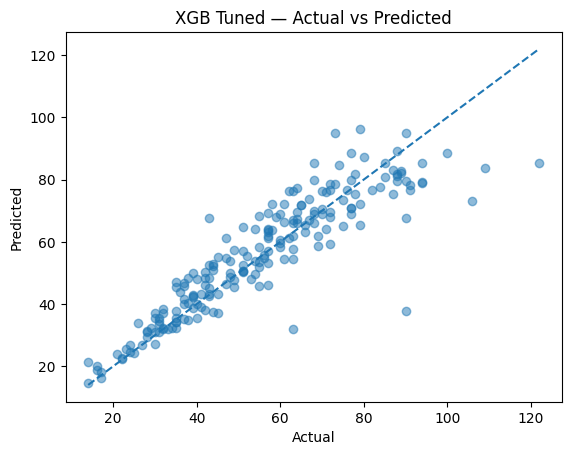

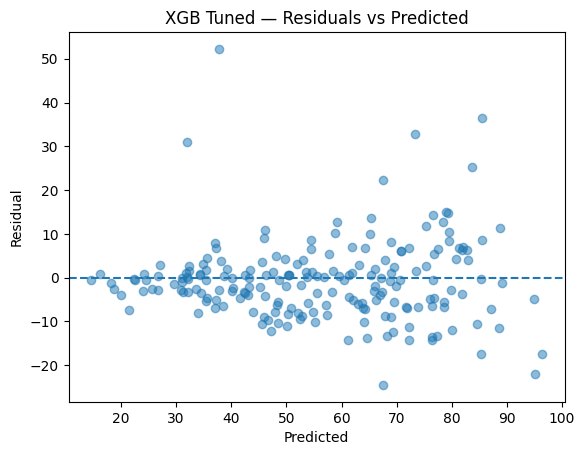

In [ ]:
best_xgb = rand_xgb.best_estimator_

best_xgb.fit(X_train, y_train)
pred_xgb = best_xgb.predict(X_test)

print("XGB Tuned Test -> MAE:", round(mean_absolute_error(y_test, pred_xgb), 3),
      "| RMSE:", round(np.sqrt(mean_squared_error(y_test, pred_xgb)), 3),
      "| R²:", round(r2_score(y_test, pred_xgb), 3))

plt.scatter(y_test, pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], ls="--")
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("XGB Tuned — Actual vs Predicted"); plt.show()

res_xgb = y_test - pred_xgb
plt.scatter(pred_xgb, res_xgb, alpha=0.5)
plt.axhline(0, ls="--")
plt.xlabel("Predicted"); plt.ylabel("Residual"); plt.title("XGB Tuned — Residuals vs Predicted"); plt.show()


##Main MOdel

###LightGBM

In [ ]:
pipe_lgb = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LGBMRegressor(
        random_state=42,
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        n_jobs=-1,
        force_row_wise="true"
    ))
])

pipe_lgb.fit(X_train, y_train)
eval_train_test(pipe_lgb, X_train, y_train, X_test, y_test, "LightGBM (baseline)")

[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 26
[LightGBM] [Info] Start training from score 57.053750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


####Hypermeter tuning LightBGM

In [ ]:
param_dist_lgb = {
    "model__n_estimators": [300, 500, 800, 1200],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__num_leaves": [15, 31, 63, 127],
    "model__max_depth": [-1, 5, 7, 9],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "model__reg_lambda": [0.0, 0.5, 1.0, 2.0],
    "model__reg_alpha": [0.0, 0.1, 0.5]
}

rand_lgb = RandomizedSearchCV(
    estimator=pipe_lgb,
    param_distributions=param_dist_lgb,
    n_iter=15,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    random_state=42,
    verbose=0
)

rand_lgb.fit(X_train, y_train)
print("Best params (LGBM):", rand_lgb.best_params_)
print("Best CV MAE:", -rand_lgb.best_score_)


[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 26
[LightGBM] [Info] Start training from score 57.053750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [ ]:
best_lgb = rand_lgb.best_estimator_
eval_train_test(best_lgb, X_train, y_train, X_test, y_test, "LightGBM (tuned)")


=== LightGBM (tuned) ===
Train -> MAE: 6.122 | RMSE: 9.533 | R²: 0.817
Test  -> MAE: 6.896 | RMSE: 9.513 | R²: 0.798


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


####Crossvalidation LightBGM

In [ ]:
report_cv(best_lgb, df[num_cols + cat_cols], df["Delivery_Time_min"], "LightGBM (Tuned)")

[LightGBM] [Info] Total Bins 852

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 26
[LightGBM] [Info] Start training from score 57.053750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 28
[LightGBM] [Info] Start training from score 56.9162

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 28
[LightGBM] [Info] Start training from score 56.367500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 28
[LightGBM] [Info] Start training from score 56.916250
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 28
[LightGBM] [Info] Start training from score 56.770000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 28
[LightGBM] [Info] Start training from score 56.367500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 26
[LightGBM] [Info] Start training from score 57.053750


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 28
[LightGBM] [Info] Start training from score 56.916250
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 28
[LightGBM] [Info] Start training from score 56.770000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 28
[LightGBM] [Info] Start training from score 56.367500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

=== LightGBM (Tuned) | 5-fold CV ===
R²   : 0.747 ± 0.046
MAE  : 7.306 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


####Acutual vs Predict chat LightBGM

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


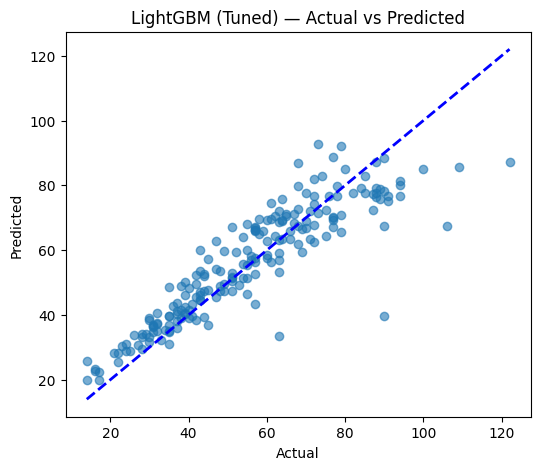

In [ ]:
y_pred = best_lgb.predict(X_test)

plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'b--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("LightGBM (Tuned) — Actual vs Predicted")
plt.show()

In [ ]:
prep = best_xgb.named_steps["preprocessor"]
model = best_xgb.named_steps["model"]

# nama fitur setelah OHE
ohe = prep.named_transformers_["cat"]
ohe_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.r_[num_cols, ohe_names]

# transform test set ke ruang fitur model
X_test_trans = prep.transform(X_test)
try:
    X_test_for_shap = X_test_trans.toarray()
except AttributeError:
    X_test_for_shap = X_test_trans

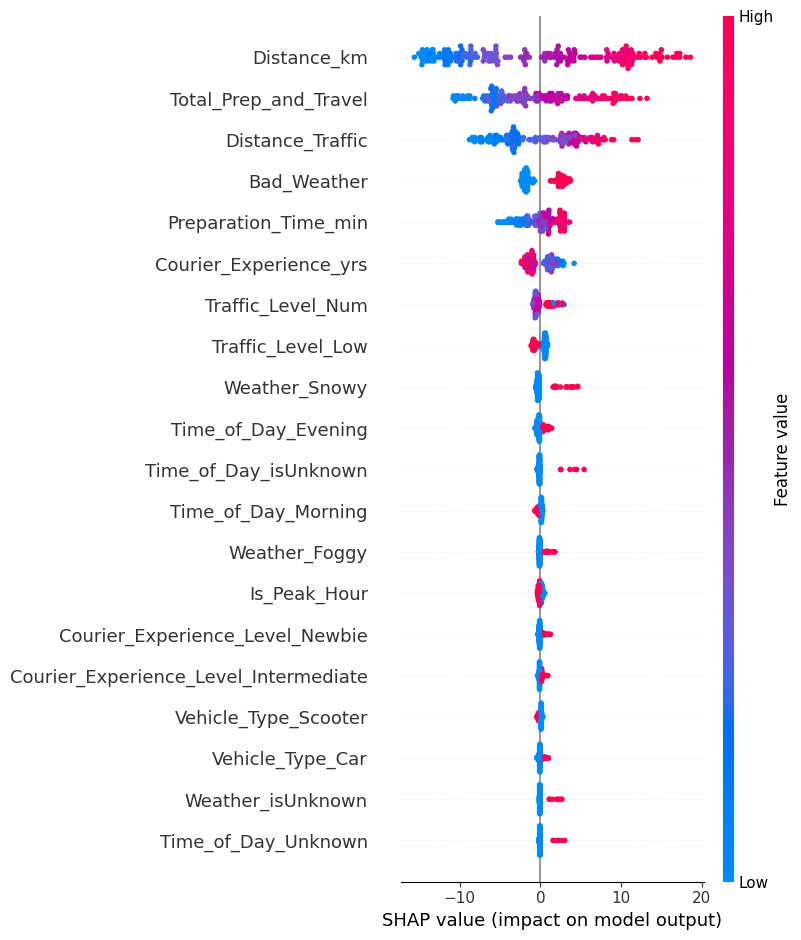

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_for_shap)

# beeswarm
shap.summary_plot(shap_values, X_test_for_shap, feature_names=feature_names, show=True)


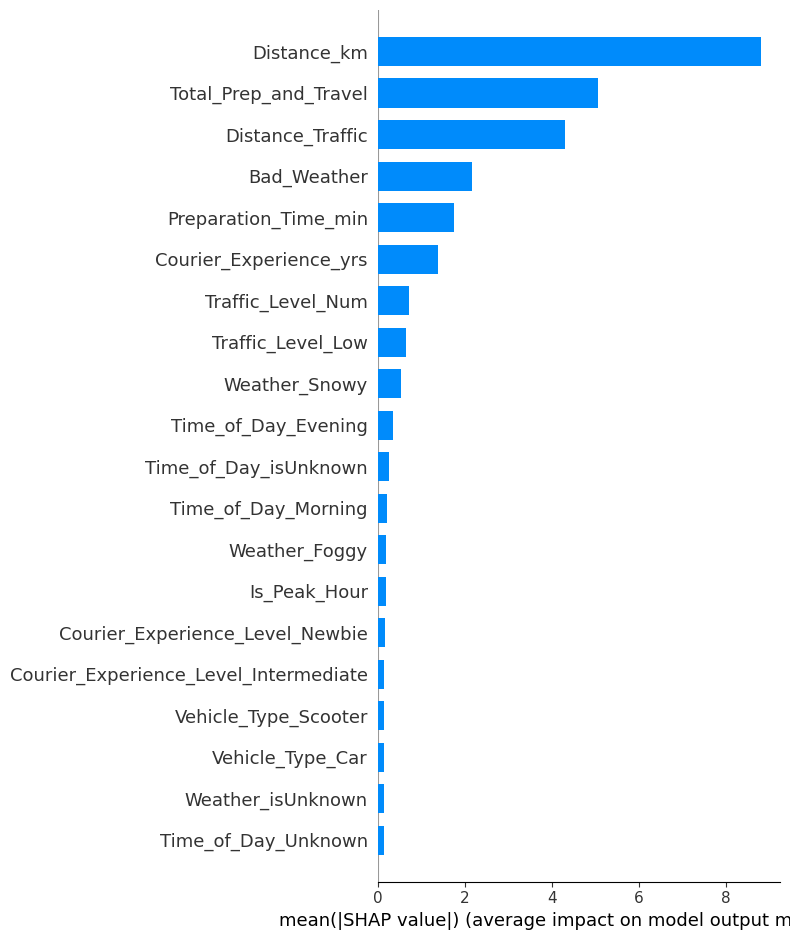

In [ ]:
shap.summary_plot(shap_values, X_test_for_shap, feature_names=feature_names, plot_type="bar", show=True)

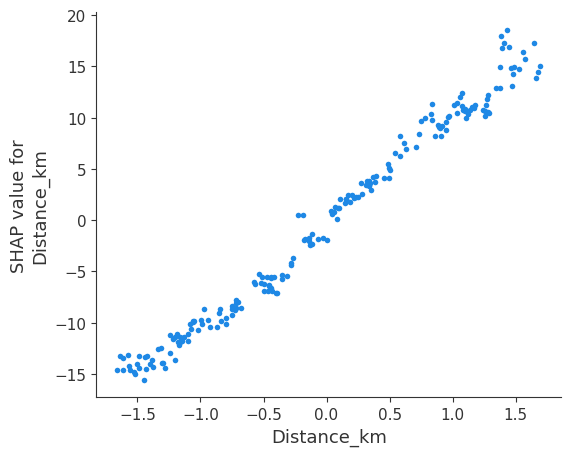

In [ ]:
shap.dependence_plot(
    "Distance_km", shap_values, X_test_for_shap,
    feature_names=feature_names, interaction_index=None, show=True
)

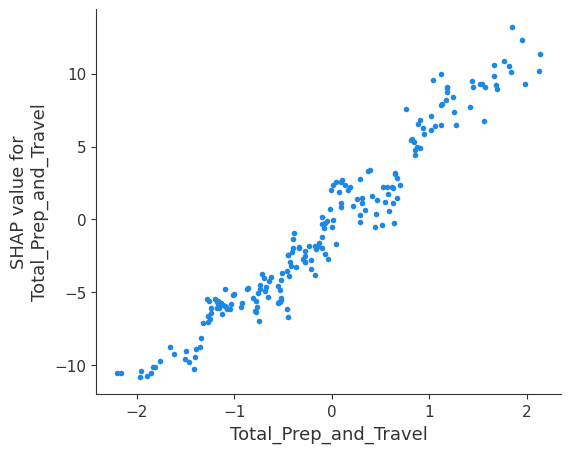

In [ ]:
shap.dependence_plot(
    "Total_Prep_and_Travel", shap_values, X_test_for_shap,
    feature_names=feature_names, interaction_index=None, show=True
)

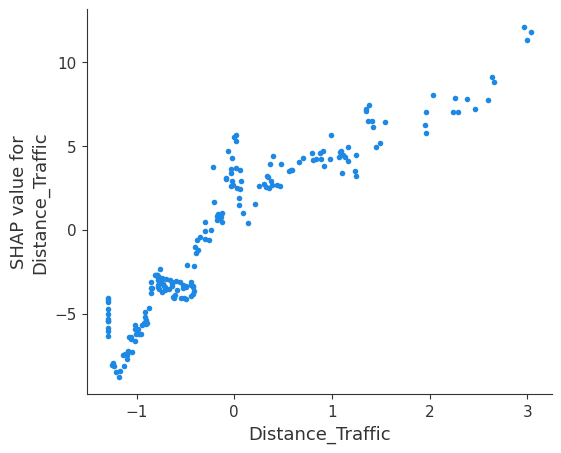

In [ ]:
shap.dependence_plot(
    "Distance_Traffic", shap_values, X_test_for_shap,
    feature_names=feature_names, interaction_index=None, show=True
)